## Homework 6: Integral

### Import Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import os
import sympy as sp

from plotly import graph_objs as go
from plotly import express as px

import time
import timeit

from mpi4py import MPI

import warnings
warnings.filterwarnings('ignore')

### Functions

In [125]:
def trapezoid_integral(f, x_min: int, x_max: int, n: int) -> float:
    integral = 0.0
    delta_x = (x_max - x_min) / (n-1)
    
    for x in np.linspace(x_min, x_max, n):
        integral += delta_x * (f(x) + f(x+delta_x)) / 2

    return integral

def func(x):
    return x**2

### Task 6.1

In [ ]:
start = 0
end = 1
n = 20000000

In [141]:
%%writefile integral_calc.py
from mpi4py import MPI
import numpy as np
import argparse

# Functions
def trapezoid_integral(f, x_min: int, x_max: int, n: int) -> float:
    integral = 0.0
    delta_x = (x_max - x_min) / (n-1)
    
    for x in np.linspace(x_min, x_max, n):
        integral += delta_x * (f(x) + f(x+delta_x)) / 2

    return integral

def func(x):
    return x**2

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Arguments
parser = argparse.ArgumentParser()
parser.add_argument('--start_intg', type=int, help='Start point for integral')
parser.add_argument('--end_intg', type=int, help='End point for integral')
parser.add_argument('--n', type=int, help='Number of points')
args = parser.parse_args()

result = trapezoid_integral(func, args.start_intg, args.end_intg, args.n)

# Output results
if rank == 0:
    print(f'Integral result: {result:.3f}')

Overwriting integral_calc.py


In [144]:
os.system(f'python integral_calc.py --start_intg={start} --end_intg={end} --n={n}')

0

### Task 6.2

In [145]:
%%writefile parallel_integral_calc.py
from mpi4py import MPI
import numpy as np
import argparse

# Functions
def trapezoid_integral(f, x_min: int, x_max: int, n: int) -> float:
    integral = 0.0
    delta_x = (x_max - x_min) / (n-1)
    
    for x in np.linspace(x_min, x_max, n):
        integral += delta_x * (f(x) + f(x+delta_x)) / 2

    return integral

def func(x):
    return x**2

# Arguments
parser = argparse.ArgumentParser()
parser.add_argument('--start_intg', type=int, help='Start point for integral')
parser.add_argument('--end_intg', type=int, help='End point for integral')
parser.add_argument('--n', type=int, help='Number of points')
args = parser.parse_args()

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Chunk range
N = np.abs(args.end_intg) - np.abs(args.start_intg)
chunk_size = N // size

start = args.start_intg + rank * chunk_size
end = start + chunk_size if rank != size - 1 else args.end_intg

local_result = trapezoid_integral(func, start, end, n=args.n//size)

global_sum = None
if rank == 0:
    global_sum = np.array([0], dtype=np.float64)


comm.Reduce(np.array([local_result]), global_sum, op=MPI.SUM, root=0)
#MPI.Finalize()

# Output results
if rank == 0:
    print(f"Интеграл | x**2 | от {args.start_intg} до {args.end_intg}: {global_sum[0]:.3f}")

Overwriting parallel_integral_calc.py


In [146]:
os.system(f'mpiexec -n 2 python parallel_integral_calc.py --start_intg={start} --end_intg={end} --n={n}')

0

### Task 6.3

In [156]:
num_processes = np.arange(1, 7, 1)
exec_time = np.zeros_like(num_processes)
for i, procs in enumerate(num_processes):
        if procs == 1:
                start_time = time.time()
                os.system(f'python integral_calc.py --start_intg={start} --end_intg={end} --n={n}')
                end_time = time.time()
        else:
                start_time = time.time()
                os.system(f'mpiexec -n {procs} python parallel_integral_calc.py --start_intg={start} --end_intg={end} --n={n}')
                end_time = time.time()
        
        exec_time[i] = end_time - start_time

In [161]:
print(f'Speed up 1 process vs 2 processes: {(exec_time[0] / exec_time[1]):.2f}')

Speed up 1 process vs 2 processes: 2.00


### Task 6.4

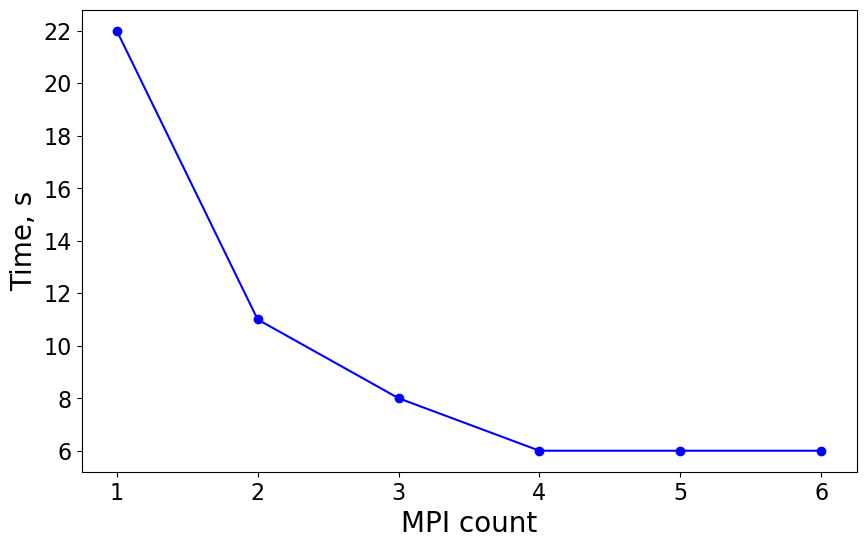

In [159]:
plt.figure(figsize=(10, 6))
plt.plot(num_processes, exec_time, marker='o', color='blue')
plt.xlabel('MPI count', fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Time, s', fontsize=20)
plt.yticks(fontsize=16)
plt.show()

### Task 6.5

In [164]:
result = trapezoid_integral(func, start, end, n=100000)

x = sp.symbols('x')
f = x**2
integral_result = sp.integrate(f, (x, start, end))

print(f'My Integral result: {result:.3f}')
print("SciPy Integral result:", integral_result)

My Integral result: 0.333
SciPy Integral result: 1/3
